In [1]:
import scipy.linalg as la
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from helper_functions.grape_functions import *
from main_grape.Grape_original import Grape
from helper_functions.qutip_open_verification import *
from helper_functions.qutip_mmt_verification import *
import h5py
%pylab inline

print parentdir
from IPython import display


Populating the interactive namespace from numpy and matplotlib
/home/nelson/Simulations/Mohamed/OQOC_Github


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:


#Defining time scales
total_time = 100
steps = 300
state_transfer = True
RWA = True
RFT = True

#Defining H0





qubit_state_num = 2

fq= 4.6/(2*np.pi)
kappa = 0.05
gamma = 0.001
g = 0.05

mode_state_num = 25
#g = 2.*np.pi*0.1 #GHz
fc = 5.0/(2*np.pi) #GHz
state_num = qubit_state_num * mode_state_num
if RFT:
    fq = fq-fc
    fc = 0
    
wc = 2*np.pi*fc
wa = 2*np.pi*fq


alpha = 0.224574
ens = np.array([ 2*np.pi*ii*(fq - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
H0q = np.kron(np.identity(mode_state_num),np.diag(ens))

a   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),1),np.identity(qubit_state_num))
adag   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),-1),np.identity(qubit_state_num))
sm = np.kron(np.identity(mode_state_num),np.diag(np.sqrt(np.arange(1,qubit_state_num)),1))
smdag = np.kron(np.identity(mode_state_num),np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))

if RWA:
     H0 = wc * np.dot(adag,a) + H0q + g * (np.dot(adag,sm) + np.dot(a,smdag))
else:
     H0 = wc * np.dot(adag,a) + H0q +  g * np.dot((adag + a),(sm + smdag))
#Defining Forbidden sates


#Defining Concerned states (starting states)
psi0=[0,1]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,2]
states_draw_names = ['g0','e0','g1']



#Defining U (Target)
if state_transfer:
    U =[]
    U1 = np.zeros(state_num,dtype=complex)
    U1[1]=1
    U1[0]=0
    U.append(U1)
    U2 = np.zeros(state_num,dtype=complex)
    U2[0]=1
    U.append(U2)
    
else:
    Ut_c = la.expm((0-1j)*total_time*H0)
    Ct_c = Ut_c.copy()
    Ct_c[1,0] = 1
    Ct_c[0,1] = 1
    Ct_c[0,0] = 0
    Ct_c[1,1] = 0
    U = Ct_c

print np.shape(U)
#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num)
U0= q_identity

#Defining control Hs
IX = a + adag
IY = (0+1j)* (a-adag)
Hops = [IX]
ops_max_amp = [0.1]
Hnames =['HI']

#Defining convergence parameters
max_iterations = 5000
decay = max_iterations/2
convergence = {'rate':0.05, 'update_step':10, 'max_iterations':max_iterations,\
               'conv_target':1e-6,'learning_rate_decay':decay}
reg_coeffs = {'envelope' : 1000,  'dwdt':10000,'d2wdt2':1000}
reg_coeffs = {'envelope' : 0,  'dwdt':0,'d2wdt2':0}
#, 'forbidden':100 , 'states_forbidden_list': [3]
#reg_coeffs = { 'speed_up':100}
#reg_coeffs = {'envelope' : 0,  'dwdt':0,'d2wdt2':0}
#multi_mode = {'dressed':dressed, 'vectors':v_c, 'qnum':qubit_state_num, 'mnum': mode_state_num,\
              #'f':freq_ge, 'es':w_c, 'g1':qm_g1, 'D':D, 'Interpolation':True, 'Modulation':True}

    #Defining initial pulses

print len(U)


(2, 50)
2


In [3]:

c_ops=[]
c_ops.append(np.sqrt(gamma)*sm)
c_ops.append(np.sqrt(kappa)*a)
#c_ops.append(ef)

#print c_ops
print gamma


0.001


In [4]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 2

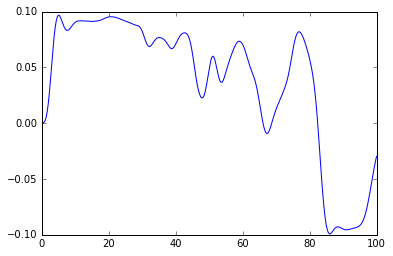

In [5]:
import h5py
u0=[]
with h5py.File('/home/mohamed/Data/00475_JC.h5','r') as hf:
    intr = 0.91*np.array(hf.get('uks'))[-1]
    u0.append(np.interp(np.linspace(0,total_time, steps),np.linspace(0,total_time, len(intr[0])),intr[0]))

#u0 = None
#u0 = []

u0=[]
with h5py.File('/home/nelson/Simulations/Mohamed/00072_JC.h5','r') as hf:
    intr = 0.95*butter_lowpass_filter(np.array(hf.get('uks'))[-1],cutoff,fs)
    u0.append(np.interp(np.linspace(0,total_time, steps),np.linspace(0,total_time, len(intr[0])),intr[0]))

signal = 0.07*np.tanh(np.linspace(0,total_time, steps)/10)
#signal = 0.095*np.cos(np.linspace(0,total_time, steps)/1.5)

#u0.append(signal)
#u0.append(signal)
#u0.append(2*np.ones(steps))

#u0 = None
plot (np.linspace(0,total_time, steps), u0[0])
#u0 = None
#u0 = []
#u0.append(np.clip(0.02*np.random.normal(size= steps),-0.1,0.1))
#plot(np.linspace(0,total_time, steps),u0[0])

TypeError: 'NoneType' object is not iterable

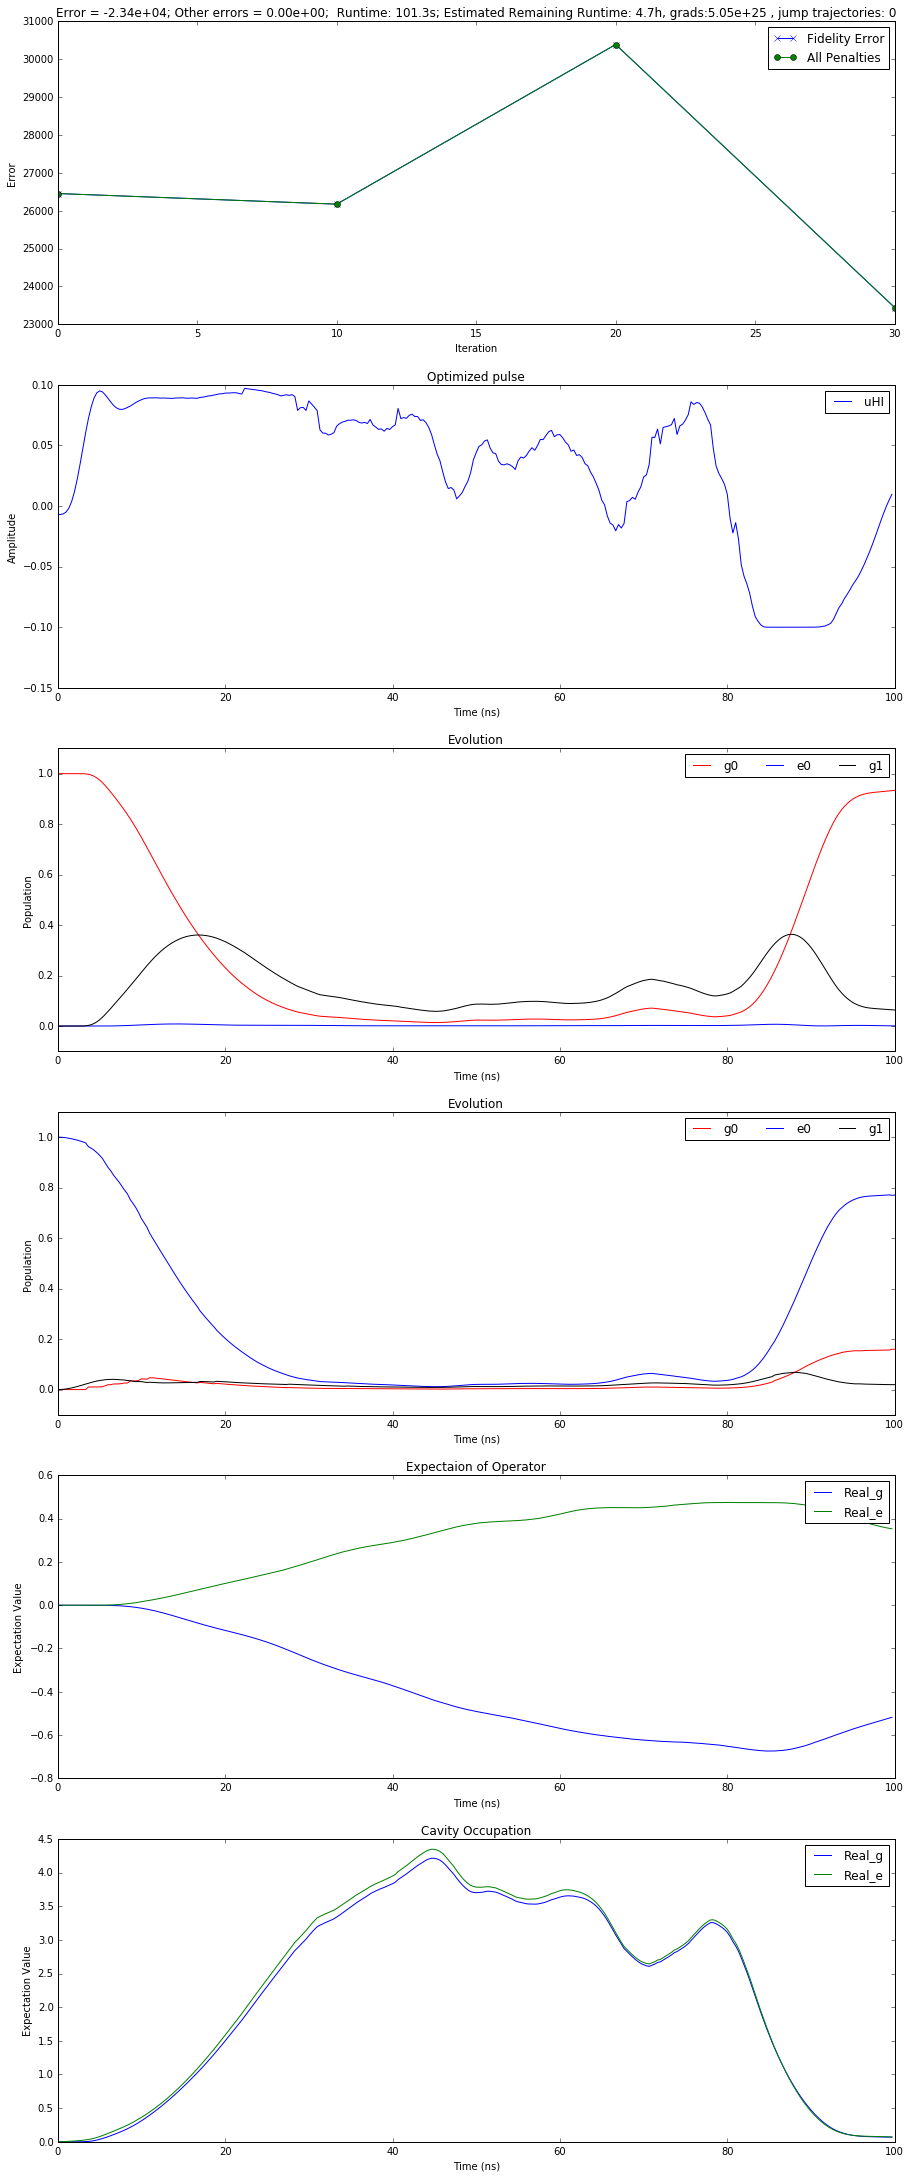

In [6]:
 #Extra options
#reg_coeffs = reg_coeffs,draw = [states_draw_list,states_draw_names] ,forbidden = states_forbidden_list,multi_mode = multi_mode,
#maxA = ops_max_amp,use_gpu = True

      
uks,U_final = Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence=convergence, draw = [states_draw_list,states_draw_names],  
                    
                    show_plots = True, c_ops = c_ops, initial_guess = u0, use_gpu = False,
       unitary_error = 1e-4,  maxA=ops_max_amp, state_transfer = state_transfer, method ='Adam', expect_op = IX, forbid_op =np.dot(adag,a),
                    reg_coeffs=reg_coeffs, file_name='JC', trajectories = 100, do_all_traj = True,
                    data_path = '/home/nelson/Simulations/Mohamed/')

In [ ]:
num = 65
mmt_qutip_verification("/home/nelson/Simulations/Mohamed/000"+str(num)+"_JC.h5", np.dot(adag,a) )
mmt_qutip_verification("/home/nelson/Simulations/Mohamed/000"+str(num)+"_JC.h5", adag+a )
mmt_qutip_verification("/home/nelson/Simulations/Mohamed/000"+str(num)+"_JC.h5", np.dot(smdag,sm))

Verifying init vector id: 0
Verifying init vector id: 1
478.579342767
Verifying init vector id: 0
Verifying init vector id: 1
61698.1847042
Verifying init vector id: 0
Verifying init vector id: 1
62769.441388


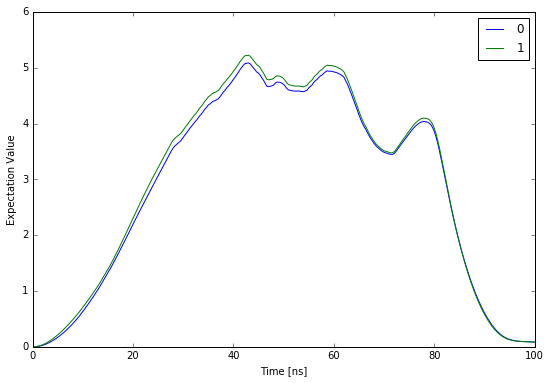

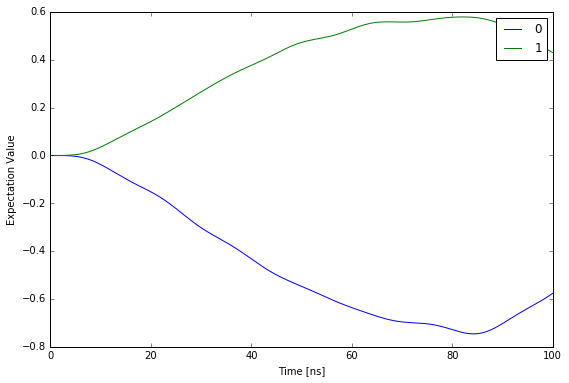

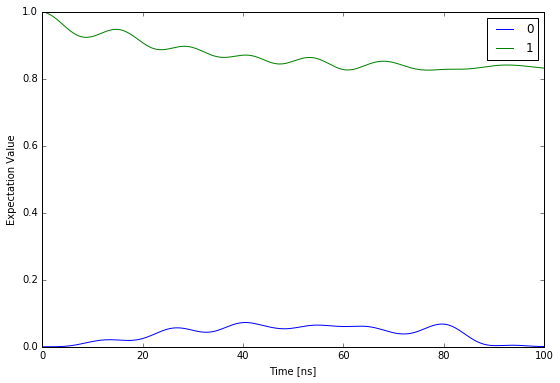

In [8]:
num = 72
mmt_qutip_verification("/home/nelson/Simulations/Mohamed/000"+str(num)+"_JC.h5", np.dot(adag,a) )
mmt_qutip_verification("/home/nelson/Simulations/Mohamed/000"+str(num)+"_JC.h5", adag+a )
mmt_qutip_verification("/home/nelson/Simulations/Mohamed/000"+str(num)+"_JC.h5", np.dot(smdag,sm))